<a href="https://colab.research.google.com/github/rpizarrog/machine_learning_r_python_casos_de_estudio/blob/main/notebook_Python/pca_dataset_ventas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivo

Aplicar reducción de dimensionalidad mediante modelo de análisis de componentes principales (PCA) en un conjunto de datos ventas de autoservicio.

# Cargar librerías


In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Simular los datos

In [ ]:
# Fijar semilla para reproducibilidad
np.random.seed(42)

# Simulación de un dataset de retail con alta correlación entre variables
n = 3000

# Variable base: ventas totales
ventas_totales = np.random.normal(1000, 200, n)

# Generamos variables muy correlacionadas con "ventas_totales"
clientes = ventas_totales / 50 + np.random.normal(0, 5, n)
ticket_promedio = ventas_totales / clientes + np.random.normal(0, 2, n)
productos_vendidos = ventas_totales / 20 + np.random.normal(0, 10, n)
ventas_online = ventas_totales * 0.4 + np.random.normal(0, 50, n)
ventas_tienda = ventas_totales * 0.6 + np.random.normal(0, 50, n)
gastos_operativos = ventas_totales * 0.3 + np.random.normal(0, 30, n)
publicidad = ventas_totales * 0.1 + np.random.normal(0, 10, n)
inventario = ventas_totales * 0.5 + np.random.normal(0, 40, n)
personal = ventas_totales / 100 + np.random.normal(0, 2, n)
descuentos = ventas_totales * 0.05 + np.random.normal(0, 5, n)
competencia_precios = np.random.normal(100, 10, n)  # Menos correlacionada
satisfaccion_clientes = np.random.normal(4, 0.5, n) # Casi independiente
dias_festivos = np.random.randint(0, 2, n)          # Binaria
region = np.random.choice(["Norte","Sur","Este","Oeste"], n)

# Construir DataFrame
datos = pd.DataFrame({
    "ventas_totales": ventas_totales,
    "clientes": clientes,
    "ticket_promedio": ticket_promedio,
    "productos_vendidos": productos_vendidos,
    "ventas_online": ventas_online,
    "ventas_tienda": ventas_tienda,
    "gastos_operativos": gastos_operativos,
    "publicidad": publicidad,
    "inventario": inventario,
    "personal": personal,
    "descuentos": descuentos,
    "competencia_precios": competencia_precios,
    "satisfaccion_clientes": satisfaccion_clientes,
    "dias_festivos": dias_festivos,
    "region": region
})

datos.to_csv('dataset_ventas.csv', index=False)

# Cargar funciones para tablas


In [ ]:
# --- INSTALACIÓN ---
!pip -q install python-docx pandas numpy

import pandas as pd
import numpy as np
from docx import Document
from docx.shared import Inches, Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.oxml.shared import OxmlElement, qn

# --- CARGA Y REDONDEO ---
# url = 'https://raw.githubusercontent.com/rpizarrog/machine_learning_r_python_casos_de_estudio/refs/heads/main/datos/datos_ventas.csv'
# df = pd.read_csv(url)
# df = np.round(df, 2)

# head10 = df.head(10).copy()
# tail10 = df.tail(10).copy()

# ====== UTILIDADES PARA DOCX ======
def _set_tbl_borders(table, show=False):
    """Bordes finos opcionales en header y perímetro; show=True para ver líneas."""
    if not show:
        # sin bordes (limpio)
        tbl = table._tbl
        borders = OxmlElement('w:tblBorders')
        for side in ('top','left','bottom','right','insideH','insideV'):
            e = OxmlElement(f'w:{side}')
            e.set(qn('w:val'), 'nil')
            borders.append(e)
        tbl.tblPr.append(borders)

def _apply_narrow_layout(doc):
    # Carta vertical, márgenes estándar
    for s in doc.sections:
        s.page_height = Inches(11)
        s.page_width  = Inches(8.5)
        s.top_margin    = Inches(1)
        s.bottom_margin = Inches(1)
        s.left_margin   = Inches(1)
        s.right_margin  = Inches(1)

def _wrap_header_text(name: str):
    # Forzar wraps suaves en encabezados largos:
    # - reemplaza '_' por salto de línea
    # - inserta salto antes de mayúsculas internas (CamelCase simple) para ayudar a envolver
    import re
    name = name.replace('_', '\n')
    name = re.sub(r'(?<!^)(?=[A-Z][a-z])', '\n', name)  # Ej: totalVentas -> total\nVentas
    return name

def _compute_equal_widths(num_cols, total_width_in=6.5):
    # Reparte ancho total de la tabla en columnas iguales
    w = total_width_in / max(1, num_cols)
    return [Inches(w)] * num_cols

def df_to_docx_narrow_table(df: pd.DataFrame, doc: Document, title: str,
                            total_width_in: float = 6.5,
                            font_size_pt: float = 9.5,
                            show_borders: bool = False):
    """
    Inserta una tabla 'angosta' en el Document:
      - una sola pieza (todas las columnas)
      - ancho fijo: table.autofit=False y anchos de columna iguales
      - tipografía compacta
      - encabezados con saltos de línea para evitar desbordes
    """
    # Título
    p = doc.add_paragraph(title)
    p.style = doc.styles['Heading 2']
    p.paragraph_format.space_after = Pt(6)

    # Conversión a str para evitar NaN
    safe = df.copy()
    for c in safe.columns:
        safe[c] = safe[c].astype(str)

    n_rows, n_cols = safe.shape
    table = doc.add_table(rows=0, cols=n_cols)
    _set_tbl_borders(table, show=show_borders)

    # Header
    hdr_cells = table.add_row().cells
    for j, col in enumerate(safe.columns):
        # Encabezado con posibles saltos de línea
        header_text = _wrap_header_text(str(col))
        # Escribimos con saltos reales en Word
        para = hdr_cells[j].paragraphs[0]
        for k, frag in enumerate(header_text.split('\n')):
            run = para.add_run(frag if k == 0 else ("\n" + frag))
            run.bold = True
            run.font.size = Pt(font_size_pt)
        para.alignment = WD_ALIGN_PARAGRAPH.CENTER

    # Filas
    for i in range(n_rows):
        row_cells = table.add_row().cells
        for j, col in enumerate(safe.columns):
            para = row_cells[j].paragraphs[0]
            run = para.add_run(str(safe.iloc[i, j]))
            run.font.size = Pt(font_size_pt)
            para.alignment = WD_ALIGN_PARAGRAPH.LEFT

    # Anchos fijos
    table.autofit = False
    col_widths = _compute_equal_widths(n_cols, total_width_in=total_width_in)
    for j, w in enumerate(col_widths):
        table.columns[j].width = w
        # Forzar ancho "preferido"
        for cell in table.columns[j].cells:
            cell.width = w

    # Espacio después de la tabla
    doc.add_paragraph("")

def export_docx_narrow(head10, tail10,
                       path_docx_both="tablas_datos_head_tail_word_narrow.docx",
                       path_docx_head="tablas_datos_head10_word_narrow.docx",
                       path_docx_tail="tablas_datos__tail10_word_narrow.docx",
                       total_width_in=6.5, font_size_pt=9.5, show_borders=False):
    # Documento con ambas tablas (una debajo de la otra)
    doc_both = Document()
    _apply_narrow_layout(doc_both)
    df_to_docx_narrow_table(head10, doc_both, "Vista previa (primeros 10 registros)",
                            total_width_in, font_size_pt, show_borders)
    df_to_docx_narrow_table(tail10, doc_both, "Vista previa (últimos 10 registros)",
                            total_width_in, font_size_pt, show_borders)
    doc_both.save(path_docx_both)

    # Documentos individuales
    doc_h = Document(); _apply_narrow_layout(doc_h)
    df_to_docx_narrow_table(head10, doc_h, "Vista previa (primeros 10 registros)",
                            total_width_in, font_size_pt, show_borders)
    doc_h.save(path_docx_head)

    doc_t = Document(); _apply_narrow_layout(doc_t)
    df_to_docx_narrow_table(tail10, doc_t, "Vista previa (últimos 10 registros)",
                            total_width_in, font_size_pt, show_borders)
    doc_t.save(path_docx_tail)

# ====== HTML EN UNA SOLA TABLA ANGOSTA ======
def df_to_html_narrow_single_table(df: pd.DataFrame, title: str = "", table_width_px: int = 700):
    safe = df.copy()
    for c in safe.columns:
        safe[c] = safe[c].astype(str)

    # CSS: tabla angosta, layout fijo, wrap agresivo
    css = f"""
    <style>
      body {{ font-family: Arial, Helvetica, sans-serif; font-size: 12pt; line-height: 1.35; margin: 0; padding: 0.2in; }}
      h2 {{ font-size: 14pt; margin: 0 0 0.15in 0; }}
      table.narrow {{
        width: {table_width_px}px;
        table-layout: fixed;
        border-collapse: collapse;
        border: 1px solid #ddd;
        font-size: 10pt;
      }}
      table.narrow th, table.narrow td {{
        border: 1px solid #ddd;
        padding: 6px 8px;
        vertical-align: top;
        word-wrap: break-word;
        overflow-wrap: anywhere;
        white-space: normal;
      }}
      table.narrow th {{
        background: #f4f4f4;
        text-align: center;
        font-weight: bold;
      }}
    </style>
    """

    # Encabezados con "soft wrap": reemplaza '_' por <br>
    def wrap_header(col):
        import re
        col = str(col).replace('_', '<br>')
        col = re.sub(r'(?<!^)(?=[A-Z][a-z])', '<br>', col)
        return col

    html = [f"<!DOCTYPE html><html><head><meta charset='utf-8'>{css}</head><body>"]
    if title:
        html.append(f"<h2>{title}</h2>")
    html.append("<table class='narrow'><thead><tr>")
    for col in safe.columns:
        html.append(f"<th>{wrap_header(col)}</th>")
    html.append("</tr></thead><tbody>")

    for _, row in safe.iterrows():
        html.append("<tr>")
        for col in safe.columns:
            html.append(f"<td>{row[col]}</td>")
        html.append("</tr>")
    html.append("</tbody></table></body></html>")
    return "".join(html)

def export_html_narrow(head10, tail10,
                       path_html_head="tablas_datos_head10_epub_narrow.html",
                       path_html_tail="tablas_datos_tail10_epub_narrow.html",
                       table_width_px=700):
    h1 = df_to_html_narrow_single_table(head10, "Vista previa (primeros 10 registros)", table_width_px)
    h2 = df_to_html_narrow_single_table(tail10, "Vista previa (últimos 10 registros)", table_width_px)
    with open(path_html_head, "w", encoding="utf-8") as f:
        f.write(h1)
    with open(path_html_tail, "w", encoding="utf-8") as f:
        f.write(h2)








# Cargar datos

In [ ]:
datos = pd.read_csv('https://raw.githubusercontent.com/rpizarrog/machine_learning_r_python_casos_de_estudio/refs/heads/main/datos/datos_ventas.csv')

# Describir datos


In [ ]:

print(datos.describe())


       ventas_totales     clientes  ticket_promedio  productos_vendidos  \
count     3000.000000  3000.000000      3000.000000         3000.000000   
mean      1006.400167    19.936786        56.105850           50.109553   
std        197.361517     6.374519        33.881869           14.009489   
min        351.746532    -0.971268      -573.006380            1.511240   
25%        874.491772    15.627464        43.075133           40.425754   
50%       1004.872963    19.947442        50.214080           50.376095   
75%       1134.718177    24.188212        61.230371           59.355799   
max       1785.247541    43.010450       784.974857           97.393110   

       ventas_online  ventas_tienda  gastos_operativos   publicidad  \
count    3000.000000    3000.000000        3000.000000  3000.000000   
mean      404.291191     604.749959         301.807416   100.540574   
std        92.604650     128.532193          66.441699    21.772351   
min        67.030781     183.172770     

In [ ]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ventas_totales         3000 non-null   float64
 1   clientes               3000 non-null   float64
 2   ticket_promedio        3000 non-null   float64
 3   productos_vendidos     3000 non-null   float64
 4   ventas_online          3000 non-null   float64
 5   ventas_tienda          3000 non-null   float64
 6   gastos_operativos      3000 non-null   float64
 7   publicidad             3000 non-null   float64
 8   inventario             3000 non-null   float64
 9   personal               3000 non-null   float64
 10  descuentos             3000 non-null   float64
 11  competencia_precios    3000 non-null   float64
 12  satisfaccion_clientes  3000 non-null   float64
 13  dias_festivos          3000 non-null   int64  
 14  region                 3000 non-null   object 
dtypes: f

# Explorar datos

## Los primeros 10 registros


In [ ]:
np.round(datos, 2).head(10)
head10 = np.round(datos, 2).head(10)
head10



,ventas_totales,clientes,ticket_promedio,productos_vendidos,ventas_online,ventas_tienda,gastos_operativos,publicidad,inventario,personal,descuentos,competencia_precios,satisfaccion_clientes,dias_festivos,region
0,1099.34,12.45,86.09,62.62,498.48,652.43,339.46,135.05,522.82,9.43,45.06,94.81,4.28,1,Oeste
1,972.35,15.15,62.94,59.35,294.99,581.78,268.26,97.04,457.62,12.05,43.34,107.03,3.92,1,Norte
2,1129.54,20.52,53.15,61.46,435.43,680.94,359.60,109.83,621.79,12.86,53.54,96.23,4.20,1,Este
3,1304.61,35.53,35.62,45.81,519.76,830.11,373.67,125.24,726.88,13.00,65.98,96.73,4.18,0,Sur
4,953.17,21.85,43.20,46.10,382.06,534.54,308.44,99.08,439.43,9.82,52.78,93.57,3.75,0,Este
5,953.17,12.39,78.63,36.10,390.29,529.59,277.73,99.18,449.83,9.51,51.13,91.71,3.82,0,Norte
6,1315.84,28.75,45.13,63.77,556.86,851.34,343.12,141.09,703.62,14.13,59.90,103.54,4.30,1,Norte
7,1153.49,15.33,72.06,67.47,459.62,668.96,316.57,106.09,598.08,9.94,55.82,104.84,4.91,0,Sur
8,906.11,23.54,40.78,48.36,344.04,480.51,258.92,87.49,480.11,10.79,45.69,102.27,4.60,0,Norte
9,1108.51,19.81,54.27,66.91,423.03,640.85,373.60,131.16,590.12,11.79,54.11,93.84,3.44,0,Sur


## Los últimos 10 registros

In [ ]:
np.round(datos, 2).tail(10)
tail10 = np.round(datos, 2).tail(10)
tail10

,ventas_totales,clientes,ticket_promedio,productos_vendidos,ventas_online,ventas_tienda,gastos_operativos,publicidad,inventario,personal,descuentos,competencia_precios,satisfaccion_clientes,dias_festivos,region
2990,1303.28,28.75,48.53,59.94,588.87,829.08,352.21,148.84,671.51,12.60,69.64,102.78,4.40,0,Este
2991,1120.42,23.94,48.58,41.51,493.84,723.47,323.72,117.29,533.52,14.85,57.40,107.42,2.79,0,Norte
2992,1014.41,15.30,66.01,46.66,416.38,587.16,315.62,112.58,504.55,11.90,50.81,90.69,3.60,1,Este
2993,957.56,21.75,40.41,38.41,395.05,590.30,308.01,99.77,428.03,7.11,41.35,104.60,4.70,1,Oeste
2994,809.62,20.51,39.44,44.99,308.65,420.33,220.29,84.08,363.34,5.57,31.93,77.71,4.15,1,Sur
2995,1015.50,21.17,48.18,38.96,360.72,658.55,291.43,113.20,537.25,9.00,47.60,89.51,3.62,1,Oeste
2996,1051.55,26.79,41.58,51.85,482.48,591.76,359.28,111.84,530.41,13.40,54.39,95.43,3.40,1,Norte
2997,751.65,8.95,87.20,45.96,366.27,490.25,260.35,77.27,344.78,6.51,34.65,103.57,4.42,1,Este
2998,1066.84,23.68,43.69,52.33,382.53,582.64,326.30,108.74,538.20,6.88,57.84,108.69,4.04,0,Sur
2999,968.95,13.53,73.23,38.98,379.89,632.94,223.59,102.28,460.19,9.23,43.68,100.83,3.89,0,Norte


# Generar tablas HTML para EPUB datos originales

In [ ]:
# ====== EJECUCIÓN ======
export_docx_narrow(
    head10, tail10,
    path_docx_both="tablas_datos_ventas_head_tail_word_narrow.docx",
    path_docx_head="tablas_datos_ventas_head10_word_narrow.docx",
    path_docx_tail="tablas_datos_ventas_tail10_word_narrow.docx",
    total_width_in=6.5,     # ancho total de tabla (ajusta a 6.0 si quieres aún más angosta)
    font_size_pt=9.5,       # tipografía compacta
    show_borders=True       # True = bordes finos visibles; False = look editorial sin líneas
)

export_html_narrow(
    head10, tail10,
    path_html_head="tablas_datos_ventas_head10_epub_narrow.html",
    path_html_tail="tablas_datos_ventas_tail10_epub_narrow.html",
    table_width_px=680       # ~6.5in a ~96dpi; ajusta si lo ves ancho
)

print("Listo. Archivos generados:")
print(" - tablas_datos_ventas_head_tail_word_narrow.docx (ambas tablas, una debajo de la otra)")
print(" - tablas_datos_ventas_head10_word_narrow.docx")
print(" - tablas_datos_ventas_tail10_word_narrow.docx")
print(" - tablas_datos_ventas_head10_epub_narrow.html")
print(" - tablas_datos_ventas_tail10_epub_narrow.html")

Listo. Archivos generados:
 - tablas_datos_ventas_head_tail_word_narrow.docx (ambas tablas, una debajo de la otra)
 - tablas_datos_ventas_head10_word_narrow.docx
 - tablas_datos_ventas_tail10_word_narrow.docx
 - tablas_datos_ventas_head10_epub_narrow.html
 - tablas_datos_ventas_tail10_epub_narrow.html


print(datos.tail(10))

# Preparación de datos
## Variables numericas y categóricas

In [ ]:
# Separar variables numéricas y categóricas
variables_numericas = datos.select_dtypes(include=[np.number]).columns.tolist()
variables_categoricas = datos.select_dtypes(exclude=[np.number]).columns.tolist()
print("Variables numéricas", variables_numericas)
print("Variables categóricas", variables_categoricas)


Variables numéricas ['ventas_totales', 'clientes', 'ticket_promedio', 'productos_vendidos', 'ventas_online', 'ventas_tienda', 'gastos_operativos', 'publicidad', 'inventario', 'personal', 'descuentos', 'competencia_precios', 'satisfaccion_clientes', 'dias_festivos']
Variables categóricas ['region']


## Normalizar datos


In [ ]:
scaler = StandardScaler()
datos_escalados = datos.copy()
datos_escalados[variables_numericas] = scaler.fit_transform(datos[variables_numericas])

In [ ]:
np.round(datos_escalados, 2).head(10)
head10 = np.round(datos_escalados, 2).head(10)
head10


,ventas_totales,clientes,ticket_promedio,productos_vendidos,ventas_online,ventas_tienda,gastos_operativos,publicidad,inventario,personal,descuentos,competencia_precios,satisfaccion_clientes,dias_festivos,region
0,0.47,-1.18,0.89,0.89,1.02,0.37,0.57,1.59,0.18,-0.21,-0.47,-0.49,0.59,0.99,Oeste
1,-0.17,-0.75,0.20,0.66,-1.18,-0.18,-0.50,-0.16,-0.43,0.73,-0.63,0.71,-0.15,0.99,Norte
2,0.62,0.09,-0.09,0.81,0.34,0.59,0.87,0.43,1.11,1.01,0.30,-0.35,0.43,0.99,Este
3,1.51,2.45,-0.60,-0.31,1.25,1.75,1.08,1.13,2.09,1.06,1.43,-0.30,0.37,-1.01,Sur
4,-0.27,0.30,-0.38,-0.29,-0.24,-0.55,0.10,-0.07,-0.60,-0.07,0.23,-0.61,-0.51,-1.01,Este
5,-0.27,-1.18,0.66,-1.00,-0.15,-0.58,-0.36,-0.06,-0.50,-0.17,0.08,-0.79,-0.35,-1.01,Norte
6,1.57,1.38,-0.32,0.97,1.65,1.92,0.62,1.86,1.87,1.47,0.88,0.37,0.63,0.99,Norte
7,0.75,-0.72,0.47,1.24,0.60,0.50,0.22,0.25,0.88,-0.02,0.51,0.49,1.88,-1.01,Sur
8,-0.51,0.56,-0.45,-0.13,-0.65,-0.97,-0.65,-0.60,-0.22,0.28,-0.42,0.24,1.25,-1.01,Norte
9,0.52,-0.02,-0.05,1.20,0.20,0.28,1.08,1.41,0.81,0.63,0.35,-0.58,-1.15,-1.01,Sur


In [ ]:
np.round(datos_escalados, 2).tail(10)
tail10 = np.round(datos_escalados, 2).tail(10)
tail10

,ventas_totales,clientes,ticket_promedio,productos_vendidos,ventas_online,ventas_tienda,gastos_operativos,publicidad,inventario,personal,descuentos,competencia_precios,satisfaccion_clientes,dias_festivos,region
2990,1.50,1.38,-0.22,0.70,1.99,1.75,0.76,2.22,1.57,0.92,1.76,0.29,0.83,-1.01,Este
2991,0.58,0.63,-0.22,-0.61,0.97,0.92,0.33,0.77,0.28,1.72,0.65,0.75,-2.48,-1.01,Norte
2992,0.04,-0.73,0.29,-0.25,0.13,-0.14,0.21,0.55,0.01,0.67,0.05,-0.89,-0.82,0.99,Este
2993,-0.25,0.28,-0.46,-0.84,-0.10,-0.11,0.09,-0.04,-0.71,-1.03,-0.81,0.47,1.46,0.99,Oeste
2994,-1.00,0.09,-0.49,-0.37,-1.03,-1.44,-1.23,-0.76,-1.31,-1.57,-1.67,-2.16,0.32,0.99,Sur
2995,0.05,0.19,-0.23,-0.80,-0.47,0.42,-0.16,0.58,0.31,-0.36,-0.24,-1.01,-0.77,0.99,Oeste
2996,0.23,1.08,-0.43,0.12,0.84,-0.10,0.87,0.52,0.25,1.21,0.38,-0.43,-1.23,0.99,Norte
2997,-1.29,-1.72,0.92,-0.30,-0.41,-0.89,-0.62,-1.07,-1.49,-1.24,-1.42,0.37,0.88,0.99,Este
2998,0.31,0.59,-0.37,0.16,-0.24,-0.17,0.37,0.38,0.32,-1.11,0.69,0.87,0.09,-1.01,Sur
2999,-0.19,-1.01,0.51,-0.79,-0.26,0.22,-1.18,0.08,-0.41,-0.27,-0.60,0.10,-0.21,-1.01,Norte


# Generar tablas HTML para EPUB y DOC de datos escalados


In [ ]:
# ====== EJECUCIÓN ======
export_docx_narrow(
    head10, tail10,
    path_docx_both="tablas_datos_ventas_escalados_head_tail_word_narrow.docx",
    path_docx_head="tablas_datos_ventas_escalados_head10_word_narrow.docx",
    path_docx_tail="tablas_datos_ventas_escalados_tail10_word_narrow.docx",
    total_width_in=6.5,     # ancho total de tabla (ajusta a 6.0 si quieres aún más angosta)
    font_size_pt=9.5,       # tipografía compacta
    show_borders=True       # True = bordes finos visibles; False = look editorial sin líneas
)

export_html_narrow(
    head10, tail10,
    path_html_head="tablas_datos_ventas_escalados_head10_epub_narrow.html",
    path_html_tail="tablas_datos_ventas_escalados_tail10_epub_narrow.html",
    table_width_px=680       # ~6.5in a ~96dpi; ajusta si lo ves ancho
)

print("Listo. Archivos generados:")
print(" - tablas_datos_ventas_head_escalados_tail_word_narrow.docx (ambas tablas, una debajo de la otra)")
print(" - tablas_datos_ventas_head10_escalados_word_narrow.docx")
print(" - tablas_datos_ventas_tail10_escalados_word_narrow.docx")
print(" - tablas_datos_ventas_head10_escalados_epub_narrow.html")
print(" - tablas_datos_ventas_tail10_escalados_epub_narrow.html")


Listo. Archivos generados:
 - tablas_datos_ventas_head_escalados_tail_word_narrow.docx (ambas tablas, una debajo de la otra)
 - tablas_datos_ventas_head10_escalados_word_narrow.docx
 - tablas_datos_ventas_tail10_escalados_word_narrow.docx
 - tablas_datos_ventas_head10_escalados_epub_narrow.html
 - tablas_datos_ventas_tail10_escalados_epub_narrow.html


# Aplicar el modelo de PCA

In [ ]:
# Construir el PCA
pca = PCA()
pca.fit(datos_escalados[variables_numericas])

PCA()

## Autovalores


In [ ]:
print("=" * 60)
print("AUTOVALORES (EIGENVALUES)")
print("=" * 60)
autovalores = pca.explained_variance_
for i, valor in enumerate(autovalores):
    print(f"Componente {i+1}: {valor:.4f}")

AUTOVALORES (EIGENVALUES)
Componente 1: 7.4236
Componente 2: 1.2752
Componente 3: 1.0468
Componente 4: 0.9847
Componente 5: 0.9701
Componente 6: 0.4956
Componente 7: 0.4699
Componente 8: 0.3159
Componente 9: 0.2686
Componente 10: 0.2081
Componente 11: 0.2060
Componente 12: 0.1690
Componente 13: 0.1432
Componente 14: 0.0280


## Autovectores


In [ ]:
print("\n" + "=" * 60)
print("AUTOVECTORES (COMPONENTES PRINCIPALES)")
print("=" * 60)
autovectores = pca.components_
autovectores_df = pd.DataFrame(autovectores,
                              columns=variables_numericas,
                              index=[f'PC{i+1}' for i in range(len(autovectores))])
print(autovectores_df.round(4))


AUTOVECTORES (COMPONENTES PRINCIPALES)
      ventas_totales  clientes  ticket_promedio  productos_vendidos  \
PC1           0.3608    0.2447          -0.0570              0.2748   
PC2           0.0565   -0.5226           0.8288              0.0862   
PC3           0.0016    0.0066           0.0271             -0.0021   
PC4          -0.0035   -0.0341           0.0477             -0.0092   
PC5          -0.0024    0.0151          -0.0383             -0.0024   
PC6          -0.0342    0.0046           0.0175             -0.3322   
PC7          -0.0772   -0.0610          -0.0782              0.8893   
PC8          -0.0053    0.7691           0.5241              0.0057   
PC9          -0.0690    0.2401           0.1424              0.1107   
PC10          0.0205   -0.0489          -0.0233             -0.0017   
PC11          0.0056   -0.0046          -0.0016              0.0391   
PC12          0.0821   -0.0933          -0.0568             -0.0108   
PC13          0.0539   -0.0178       

## Varianza explicada


In [ ]:
print("=" * 60)
print("VARIANZA EXPLICADA")
print("=" * 60)
varianza_explicada = pca.explained_variance_ratio_
varianza_acumulada = np.cumsum(varianza_explicada)

# Crear tabla de varianza
varianza_df = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(len(varianza_explicada))],
    'Autovalor': autovalores,
    'Varianza_Explicada': varianza_explicada,
    'Varianza_Acumulada': varianza_acumulada
})

print(varianza_df.round(4))

VARIANZA EXPLICADA
   Componente  Autovalor  Varianza_Explicada  Varianza_Acumulada
0         PC1     7.4236              0.5301              0.5301
1         PC2     1.2752              0.0911              0.6211
2         PC3     1.0468              0.0747              0.6959
3         PC4     0.9847              0.0703              0.7662
4         PC5     0.9701              0.0693              0.8355
5         PC6     0.4956              0.0354              0.8708
6         PC7     0.4699              0.0336              0.9044
7         PC8     0.3159              0.0226              0.9270
8         PC9     0.2686              0.0192              0.9461
9        PC10     0.2081              0.0149              0.9610
10       PC11     0.2060              0.0147              0.9757
11       PC12     0.1690              0.0121              0.9878
12       PC13     0.1432              0.0102              0.9980
13       PC14     0.0280              0.0020              1.0000


## Componentes


In [ ]:
# =============================================================================
# 4. ANÁLISIS DETALLADO
# =============================================================================
print("\n" + "=" * 60)
print("ANÁLISIS DETALLADO")
print("=" * 60)

# Componentes más importantes por varianza
print(f"\nNúmero total de componentes: {pca.n_components_}")
print(f"Varianza total explicada: {varianza_acumulada[-1]:.4f}")

# Componentes necesarios para explicar el 80% y 90% de varianza
umbral_80 = np.where(varianza_acumulada >= 0.8)[0]
umbral_90 = np.where(varianza_acumulada >= 0.9)[0]

if len(umbral_80) > 0:
    print(f"Componentes para 80% varianza: {umbral_80[0] + 1}")
if len(umbral_90) > 0:
    print(f"Componentes para 90% varianza: {umbral_90[0] + 1}")



ANÁLISIS DETALLADO

Número total de componentes: 14
Varianza total explicada: 1.0000
Componentes para 80% varianza: 5
Componentes para 90% varianza: 7


## Variables para cada componente


In [ ]:
# =============================================================================
# VARIABLES MÁS IMPORTANTES EN CADA COMPONENTE
# =============================================================================
print("\n" + "=" * 60)
print("VARIABLES MÁS IMPORTANTES POR COMPONENTE (Top 3)")
print("=" * 60)

for i, componente in enumerate(autovectores):
    # Obtener índices de las 3 variables con mayor peso absoluto
    indices_importantes = np.argsort(np.abs(componente))[-3:][::-1]

    print(f"\nComponente PC{i+1}:")
    for idx in indices_importantes:
        variable = variables_numericas[idx]
        peso = componente[idx]
        print(f"  {variable}: {peso:.4f}")


VARIABLES MÁS IMPORTANTES POR COMPONENTE (Top 3)

Componente PC1:
  ventas_totales: 0.3608
  inventario: 0.3414
  ventas_tienda: 0.3389

Componente PC2:
  ticket_promedio: 0.8288
  clientes: -0.5226
  productos_vendidos: 0.0862

Componente PC3:
  satisfaccion_clientes: 0.6362
  dias_festivos: -0.5834
  competencia_precios: 0.5026

Componente PC4:
  competencia_precios: 0.8091
  dias_festivos: 0.5729
  satisfaccion_clientes: -0.1151

Componente PC5:
  satisfaccion_clientes: 0.7613
  dias_festivos: 0.5747
  competencia_precios: -0.2959

Componente PC6:
  personal: 0.9238
  productos_vendidos: -0.3322
  ventas_online: -0.0976

Componente PC7:
  productos_vendidos: 0.8893
  personal: 0.2496
  ventas_online: -0.2417

Componente PC8:
  clientes: 0.7691
  ticket_promedio: 0.5241
  ventas_online: -0.3485

Componente PC9:
  ventas_online: 0.8067
  descuentos: -0.4110
  clientes: 0.2401

Componente PC10:
  gastos_operativos: 0.6984
  descuentos: -0.6765
  ventas_online: -0.1986

Componente PC11

## Otra alternativa visual


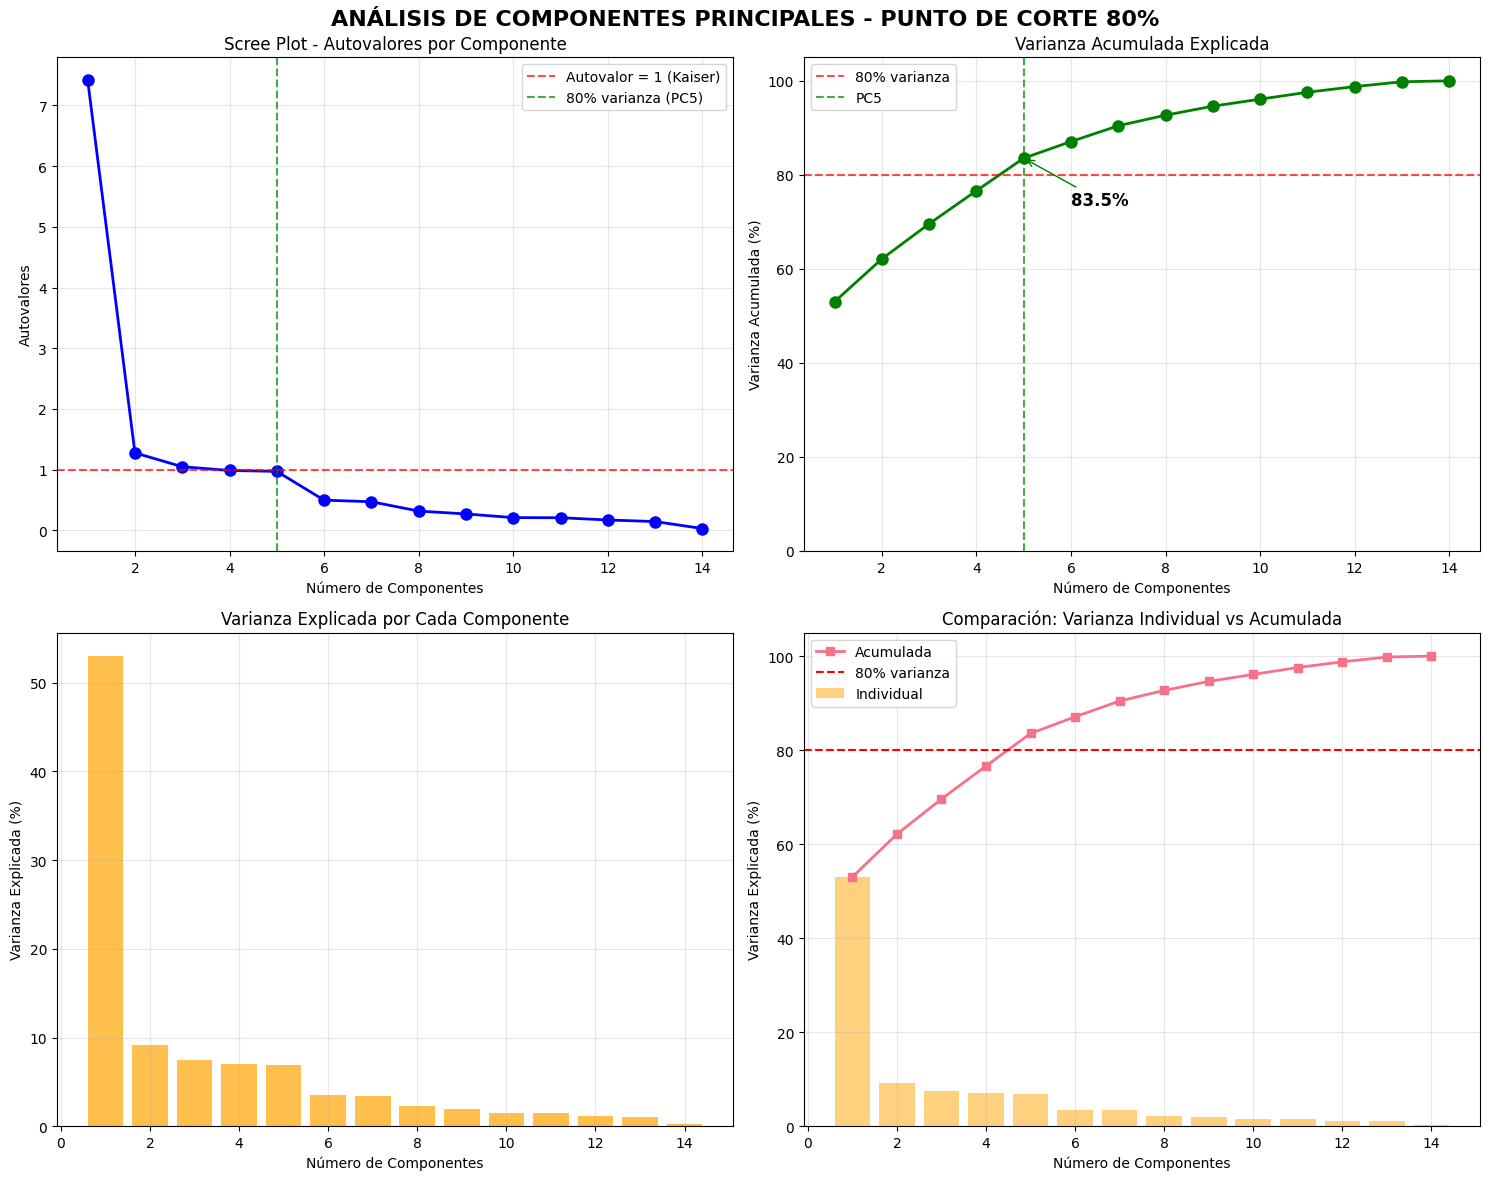

RECOMENDACIÓN DE COMPONENTES PRINCIPALES

📊 **ANÁLISIS DEL DATASET:**
   - Variables originales: 14
   - Total de componentes posibles: 14

🎯 **PUNTO DE CORTE AL 80%:**
   - Componentes necesarios: 5
   - Varianza explicada: 83.55%
   - Reducción dimensional: 14 → 5 variables
   - Porcentaje de reducción: 64.3%

📈 **DETALLE DE VARIANZA:**
   PC1: 53.01% (Acum: 53.01%)
   PC2: 9.11% (Acum: 62.11%)
   PC3: 7.47% (Acum: 69.59%)
   PC4: 7.03% (Acum: 76.62%)
   PC5: 6.93% (Acum: 83.55%)
   PC6: 3.54% (Acum: 87.08%)
   PC7: 3.36% (Acum: 90.44%)
   PC8: 2.26% (Acum: 92.70%)
   PC9: 1.92% (Acum: 94.61%)
   PC10: 1.49% (Acum: 96.10%)

💡 **INTERPRETACIÓN:**
   ✅ Buena reducción dimensional. Mantenibilidad óptima

🔧 **SUGERENCIA PRÁCTICA:**
   Usar PCA(n_components=5) para el modelo

📊 **AUTOVALORES DE LOS PRIMEROS 5 COMPONENTES:**
   PC1: 7.424
   PC2: 1.275
   PC3: 1.047
   PC4: 0.985
   PC5: 0.970

📏 **REGLA DE KAISER (autovalores > 1):** 3 componentes


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo de gráficos
plt.style.use('default')
sns.set_palette("husl")



# Obtener métricas
autovalores = pca.explained_variance_
varianza_explicada = pca.explained_variance_ratio_
varianza_acumulada = np.cumsum(varianza_explicada)

# Encontrar el número de componentes para el 80%
n_componentes_80 = np.where(varianza_acumulada >= 0.8)[0][0] + 1
porcentaje_80 = varianza_acumulada[n_componentes_80 - 1] * 100

# =============================================================================
# VISUALIZACIÓN COMPLETA
# =============================================================================
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('ANÁLISIS DE COMPONENTES PRINCIPALES - PUNTO DE CORTE 80%',
             fontsize=16, fontweight='bold')

# 1. SCREE PLOT (Autovalores)
ax1.plot(range(1, len(autovalores) + 1), autovalores, 'bo-', linewidth=2, markersize=8)
ax1.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='Autovalor = 1 (Kaiser)')
ax1.axvline(x=n_componentes_80, color='g', linestyle='--', alpha=0.7,
           label=f'80% varianza (PC{n_componentes_80})')
ax1.set_xlabel('Número de Componentes')
ax1.set_ylabel('Autovalores')
ax1.set_title('Scree Plot - Autovalores por Componente')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. VARIANZA EXPLICADA ACUMULADA
ax2.plot(range(1, len(varianza_acumulada) + 1), varianza_acumulada * 100,
        'go-', linewidth=2, markersize=8)
ax2.axhline(y=80, color='r', linestyle='--', alpha=0.7, label='80% varianza')
ax2.axvline(x=n_componentes_80, color='g', linestyle='--', alpha=0.7,
           label=f'PC{n_componentes_80}')
ax2.set_xlabel('Número de Componentes')
ax2.set_ylabel('Varianza Acumulada (%)')
ax2.set_title('Varianza Acumulada Explicada')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_ylim(0, 105)

# Añadir anotación del punto de corte
ax2.annotate(f'{porcentaje_80:.1f}%',
            xy=(n_componentes_80, varianza_acumulada[n_componentes_80-1]*100),
            xytext=(n_componentes_80+1, varianza_acumulada[n_componentes_80-1]*100-10),
            arrowprops=dict(arrowstyle='->', color='green'),
            fontsize=12, fontweight='bold')

# 3. VARIANZA EXPLICADA INDIVIDUAL
ax3.bar(range(1, len(varianza_explicada) + 1), varianza_explicada * 100,
       alpha=0.7, color='orange')
ax3.set_xlabel('Número de Componentes')
ax3.set_ylabel('Varianza Explicada (%)')
ax3.set_title('Varianza Explicada por Cada Componente')
ax3.grid(True, alpha=0.3)

# 4. COMPARACIÓN COMPONENTES vs VARIANZA
componentes = range(1, len(varianza_acumulada) + 1)
ax4.plot(componentes, varianza_acumulada * 100, 's-', label='Acumulada', linewidth=2)
ax4.bar(componentes, varianza_explicada * 100, alpha=0.5, label='Individual', color='orange')
ax4.axhline(y=80, color='r', linestyle='--', label='80% varianza')
ax4.set_xlabel('Número de Componentes')
ax4.set_ylabel('Varianza Explicada (%)')
ax4.set_title('Comparación: Varianza Individual vs Acumulada')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# RECOMENDACIÓN Y ANÁLISIS
# =============================================================================
print("=" * 70)
print("RECOMENDACIÓN DE COMPONENTES PRINCIPALES")
print("=" * 70)

print(f"\n📊 **ANÁLISIS DEL DATASET:**")
print(f"   - Variables originales: {len(variables_numericas)}")
print(f"   - Total de componentes posibles: {pca.n_components_}")

print(f"\n🎯 **PUNTO DE CORTE AL 80%:**")
print(f"   - Componentes necesarios: {n_componentes_80}")
print(f"   - Varianza explicada: {porcentaje_80:.2f}%")
print(f"   - Reducción dimensional: {len(variables_numericas)} → {n_componentes_80} variables")
print(f"   - Porcentaje de reducción: {(1 - n_componentes_80/len(variables_numericas)) * 100:.1f}%")

print(f"\n📈 **DETALLE DE VARIANZA:**")
for i in range(min(10, len(varianza_explicada))):  # Mostrar primeros 10 componentes
    print(f"   PC{i+1}: {varianza_explicada[i]*100:.2f}% (Acum: {varianza_acumulada[i]*100:.2f}%)")

print(f"\n💡 **INTERPRETACIÓN:**")
if n_componentes_80 <= 3:
    print("   ✅ Excelente reducción dimensional! Puedes visualizar en 2D/3D")
elif n_componentes_80 <= 5:
    print("   ✅ Buena reducción dimensional. Mantenibilidad óptima")
else:
    print("   ⚠️ Reducción moderada. Considerar si se necesita más componentes")

print(f"\n🔧 **SUGERENCIA PRÁCTICA:**")
print(f"   Usar PCA(n_components={n_componentes_80}) para el modelo")


# Mostrar autovalores de los componentes recomendados
print(f"\n📊 **AUTOVALORES DE LOS PRIMEROS {n_componentes_80} COMPONENTES:**")
for i in range(n_componentes_80):
    print(f"   PC{i+1}: {autovalores[i]:.3f}")

# Regla de Kaiser (autovalores > 1)
componentes_kaiser = np.sum(autovalores > 1)
print(f"\n📏 **REGLA DE KAISER (autovalores > 1):** {componentes_kaiser} componentes")

# Evaluación del modelo


# Reducción de dimensionalidad

Algunas evaluaciones que distinguen fortalezas del modelo son que el PCA para estos datos, captura alrededor del 80% de la varianza acumulada en 4 a 5 dimensiones; las variables correlacionadas se condensan en un solo factor interpretable; con las gráficas se facilita visualización y segmentación de registros.

Algunas limitantes a manera de evaluación es que algunas variables casi independientes (por ejemplo satisfacción_clientes, competencia_precios, días festivos) no se resumen bien en los primeros componentes, habrá que identificar si son críticas para el análisis, habría que analizarlas por separado o prescindir de ellas en la construcción del modelo en un segundo proceso; además, el PCA es lineal, es decir, no captura relaciones no lineales entre variables.


In [ ]:
print(f"\n" + "=" * 70)
print("CÓDIGO PARA IMPLEMENTAR LA REDUCCIÓN")
print("=" * 70)

# Reducir a 5 componentes (80% de varianza aprox)
pca = PCA(n_components=5)
pca_reducido = pca.fit_transform(datos_escalados[variables_numericas])

# Convertir a DataFrame
datos_reducido = pd.DataFrame(pca_reducido,
                           columns=[f"PC{i+1}" for i in range(pca.n_components_)])
print(datos_reducido.head(10))
print(datos_reducido.tail(10))


CÓDIGO PARA IMPLEMENTAR LA REDUCCIÓN
        PC1       PC2       PC3       PC4       PC5
0  1.085944  1.687214 -0.453103  0.185934  1.088774
1 -0.879559  0.397614 -0.320094  1.180752  0.222975
2  1.962938  0.277565 -0.480234  0.236120  0.997836
3  4.280305 -1.125286  0.692836 -0.953064 -0.174231
4 -0.483867 -0.551090 -0.041216 -1.034978 -0.758285
5 -1.286269  1.013770 -0.021598 -1.098283 -0.657911
6  4.510059 -0.233187 -0.011778  0.745807  0.916614
7  1.375754  1.103541  2.042160 -0.358483  0.654554
8 -1.142643 -0.895577  1.491294 -0.572305  0.329559
9  2.056701  0.373701 -0.427158 -0.917028 -1.289632
           PC1       PC2       PC3       PC4       PC5
2990  4.651928 -0.113262  1.266600 -0.472481 -0.058114
2991  1.969041 -0.323647 -0.638690  0.317836 -2.694850
2992  0.202343  0.725381 -1.551086 -0.006030  0.181334
2993 -1.057770 -0.758170  0.578483  0.743518  1.574803
2994 -3.307812 -0.904624 -1.488727 -1.276369  1.476460
2995 -0.074143 -0.310297 -1.562168 -0.184162  0.282507
2996 

In [ ]:
np.round(datos_reducido, 4).head(10)

,PC1,PC2,PC3,PC4,PC5
0,1.0859,1.6872,-0.4531,0.1859,1.0888
1,-0.8796,0.3976,-0.3201,1.1808,0.2230
2,1.9629,0.2776,-0.4802,0.2361,0.9978
3,4.2803,-1.1253,0.6928,-0.9531,-0.1742
4,-0.4839,-0.5511,-0.0412,-1.0350,-0.7583
5,-1.2863,1.0138,-0.0216,-1.0983,-0.6579
6,4.5101,-0.2332,-0.0118,0.7458,0.9166
7,1.3758,1.1035,2.0422,-0.3585,0.6546
8,-1.1426,-0.8956,1.4913,-0.5723,0.3296
9,2.0567,0.3737,-0.4272,-0.9170,-1.2896


In [ ]:
np.round(datos_reducido,4).tail(10)

,PC1,PC2,PC3,PC4,PC5
2990,4.6519,-0.1133,1.2666,-0.4725,-0.0581
2991,1.9690,-0.3236,-0.6387,0.3178,-2.6949
2992,0.2023,0.7254,-1.5511,-0.0060,0.1813
2993,-1.0578,-0.7582,0.5785,0.7435,1.5748
2994,-3.3078,-0.9046,-1.4887,-1.2764,1.4765
2995,-0.0741,-0.3103,-1.5622,-0.1842,0.2825
2996,1.6360,-0.6682,-1.5937,0.3354,-0.2038
2997,-3.3201,1.1586,0.1599,0.8540,1.0841
2998,0.4703,-0.6168,1.1201,0.0625,-0.7408
2999,-1.3472,0.7122,0.4972,-0.4223,-0.8324


# Evaluación del modelo

El modelo PCA que se implementó en este caso fue de reducir un conjunto de datos que representan ventas diarias con 14 variables numéricas a un conjunto de datos con sugerencia a 4 o 5 componentes.

Si se deja en 4 componentes el porcentaje de varianza explicada es aproximadamente del 76%; si se decide a 5 dimensiones, el porcentaje de varianza explicada es de aproximadamente 83%.


